In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys
sys.path.append(os.getcwd() + "/../src")

%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import handl
import util
from collections import defaultdict

In [2]:
def plot(scores_and_labels, xlabel,
         xmin=0.0, 
         xmax=0.6, 
         smoothness=20., 
         font_size=12, 
         line_width=2):
    from sklearn import neighbors

    # create and save plot
    plt.figure()
    
    # create kernel density estimator
    kde = neighbors.KernelDensity(kernel='gaussian', bandwidth = xmax / smoothness)
    # need to add another dimension as required by sklearn
    # arrays passed to kde must be 2-dimensional
    X_plot = np.reshape(np.linspace(xmin, xmax, 500), (-1, 1))
    styles = ['-', '--', '-.', ':']
    for i, (xs, label) in enumerate(scores_and_labels):
        scores = np.ravel(xs) if len(xs) < 1e5 else np.random.choice(np.ravel(xs), int(1e5))
        kde.fit(np.reshape(scores, (-1, 1)))
        densities = kde.score_samples(X_plot)
        plt.plot(X_plot[:,0], np.exp(densities), lw = line_width,
                 label = label, ls=styles[i % len(styles)])
    plt.ylabel('Density', size = font_size)
    plt.xlabel(xlabel, size = font_size)
    plt.legend(loc='best', fontsize = font_size)

In [3]:
homologs_path = "../data/homologs/sc-sp/sp-sc-homologs.txt" 

In [4]:
sp_ppi_path = "../data/ppi/biogrid/sp/sp-biogrid.v3.4.157-ppi-std.tsv" 
sc_ppi_path = "../data/ppi/biogrid/sc/sc-biogrid.v3.4.157-ppi-std.tsv" 
sc_G = util.simple_two_core(nx.read_edgelist(sc_ppi_path, encoding='ascii'), verbose=False)
sp_G = util.simple_two_core(nx.read_edgelist(sp_ppi_path, encoding='ascii'), verbose=False)

In [5]:
source_G, target_G = sp_G, sc_G
n_landmarks = 400

# FUNCTION START

In [6]:
source_nodes, target_nodes = sorted(source_G.nodes()), sorted(target_G.nodes())
homologs = handl.homologs_in_graphs(source_G, target_G, util.read_homolog_list(homologs_path))
import random
random.shuffle(homologs)
source_landmark_nodes, target_landmark_nodes = zip(*homologs[:n_landmarks])
source_non_landmark_nodes = [node for node in source_nodes if node not in set(source_landmark_nodes)]
target_non_landmark_nodes = [node for node in target_nodes if node not in set(target_landmark_nodes)]

source_n2i = dict((n,i) for i, n in enumerate(source_nodes))
target_n2i = dict((n,i) for i, n in enumerate(target_nodes))

In [7]:
source_D = handl.regularized_laplacian(source_G, source_nodes, 0.05)
target_D = handl.regularized_laplacian(target_G, target_nodes, 0.05)
source_C = handl.rkhs_factor(source_D)
homolog_idxs = [(source_n2i[s], target_n2i[t]) for (s,t) in homologs]
landmark_idxs = homolog_idxs[:n_landmarks]
source_landmark_idxs, target_landmark_idxs = zip(*landmark_idxs)
source_non_landmark_idxs = [source_n2i[n] for n in source_non_landmark_nodes]
target_non_landmark_idxs = [target_n2i[n] for n in target_non_landmark_nodes]

In [8]:
def non_landmark_idxs(n, landmark_idxs):
    return [i for i in range(n) if i not in set(landmark_idxs)]
def mmm(arr):
    return np.min(arr), np.mean(arr), np.max(arr)

In [9]:
source_C_L = source_C[source_landmark_idxs,:]
target_D_L = target_D[target_landmark_idxs, :]
T_D_1 = target_D_L[:, target_landmark_idxs]
T_D_2 = target_D_L[:, target_non_landmark_idxs]
print(source_C_L.shape, target_D_L.shape, T_D_1.shape, T_D_2.shape)

(400, 1865) (400, 5609) (400, 400) (400, 5209)


In [10]:
T_CH_2, residual, _, _ = np.linalg.lstsq(source_C_L, T_D_2)

/cbcbhomes/jfan03/.conda_envs/HANDL/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [11]:
print(np.linalg.norm(residual))
print(T_CH_2.shape)

0.0
(1865, 5209)


In [12]:
T_CH_1 = np.zeros((len(source_D), n_landmarks))
print(T_CH_1.shape)

(1865, 400)


In [13]:
for i in range(n_landmarks):
    no_landmark_target = np.delete(T_D_1[:,i], i)
    no_L_row_source_C_L = np.delete(source_C_L, i, axis=0)
    no_landmark_soln,_,_,_ = np.linalg.lstsq(no_L_row_source_C_L, no_landmark_target)
    T_CH_1[:, i] = no_landmark_soln

/cbcbhomes/jfan03/.conda_envs/HANDL/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [14]:
print(mmm(T_CH_1))
print(mmm(T_CH_2))

(-0.018830285801866603, 5.77649343643734e-07, 0.017705076087188066)
(-0.021640088682500037, 4.9045584802316e-07, 0.021337197902434796)


In [15]:
unordered_T_CH = np.hstack((T_CH_1, T_CH_2))

In [16]:
print(unordered_T_CH.shape)

(1865, 5609)


In [17]:
#print(list(target_landmark_nodes))
#print(list(target_non_landmark_nodes))
unordered_nodes = list(target_landmark_nodes) + list(target_non_landmark_nodes)
reordering_idxs = list(target_landmark_idxs) + list(target_non_landmark_idxs)
unordered_node2index = dict((n,i) for i, n in enumerate(unordered_nodes))
reorder_i2i = dict((j,i) for i, j in enumerate(reordering_idxs))
#ordered_T_CH = unordered_T_CH[:, [unordered_node2index[node] for node in target_nodes]]
ordered_T_CH = unordered_T_CH[:, [reorder_i2i[i] for i in range(len(target_nodes))]]

In [18]:
target_C_hat = ordered_T_CH.T
print(target_C_hat.shape)

(5609, 1865)


# FUNCTION END!

In [19]:
D_12 = source_C @ target_C_hat.T

In [20]:
def separate_scores(scores, landmark_pair_idxs, homolog_pair_idxs):
    ''' 
    Separate scores into the following 5 categories:
        1. Landmark - Landmark pair scores
        2. Off diagonal entries in the landmark-landmark submatrix
        3. Landmark- (non-landmark) entries in rows and columns that correspond
           to one landmark
        4. Homolog-homolog pairs
        5. Other pairs
    '''
    source_landmark_idxs, target_landmark_idxs = zip(*landmark_pair_idxs)
    source_homolog_idxs, target_homolog_idxs = zip(*homolog_pair_idxs)
    landmark_mask = np.zeros_like(scores, dtype=bool)
    
    source_landmark_target_all_mask = np.zeros_like(scores, dtype=bool)
    source_landmark_target_all_mask[source_landmark_idxs, :]  = True
    source_all_target_landmark_mask = np.zeros_like(scores, dtype=bool)
    source_all_target_landmark_mask[:, target_landmark_idxs]  = True
    landmark_landmark_mask = np.zeros_like(scores, dtype=bool) 
    landmark_landmark_mask[source_landmark_idxs, target_landmark_idxs] = True
    
    # Obtain landmark-landmark pairs
    L_L_diag_scores = scores[source_landmark_idxs, target_landmark_idxs]
    
    # Obtain landmark-landmark off diag pairs
    L_L_off_diag_mask = np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    L_L_off_diag_mask &= ~landmark_landmark_mask
    L_L_off_diag_scores = scores[L_L_off_diag_mask]
    
    # Landmark - Non-landmark pairs
    LX_mask = source_landmark_target_all_mask & ~np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    LX_scores = scores[LX_mask]
    
    XL_mask = source_all_target_landmark_mask & ~np.logical_and(source_landmark_target_all_mask, source_all_target_landmark_mask)
    XL_scores = scores[XL_mask]
    
    # Hom - Hom pairs
    H_H_mask = np.zeros_like(scores, dtype=bool)
    H_H_mask[source_homolog_idxs, target_homolog_idxs] = True
    H_H_mask[source_landmark_idxs, target_landmark_idxs] = False
    H_H_scores = scores[H_H_mask]
    
    # Obtain other scores
    other_mask = np.ones_like(scores, dtype=np.bool)
    other_mask &= ~(source_landmark_target_all_mask | source_all_target_landmark_mask | H_H_mask )
    other_scores = scores[other_mask] 

    return L_L_diag_scores,\
           L_L_off_diag_scores,\
           LX_scores,\
           XL_scores,\
           H_H_scores,\
            other_scores

In [21]:
separated_D_12_raw_scores = separate_scores(D_12, landmark_idxs, homolog_idxs)
D_12_raw_plots = list(zip(separated_D_12_raw_scores,
                         ['landmark-landmark', 'S1*T1', 'S1*T2', 'S2*T1', 'homolog-homolog', 'S2*T2']))

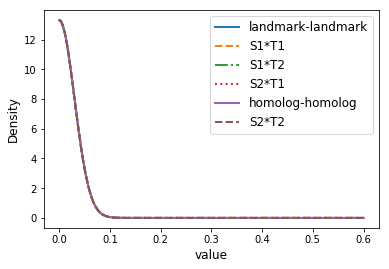

In [22]:
plot(D_12_raw_plots, 'value')

In [23]:
print(mmm(D_12))

(7.981438000442123e-10, 3.145168269953835e-05, 0.031201511229520223)


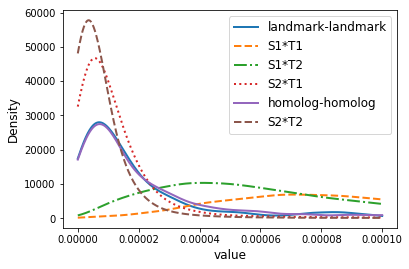

In [24]:
plot(D_12_raw_plots, 'value', xmin=0, xmax=1e-4)

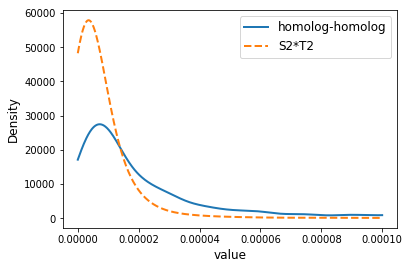

In [25]:
plot(D_12_raw_plots[-2:], 'value', xmin=0, xmax=1e-4)

In [26]:
dissim_scores = 1 / D_12
dissim_scores /= np.mean(dissim_scores)
dissim_scores_plots = list(zip(separate_scores(dissim_scores, landmark_idxs, homolog_idxs), 
                          ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))

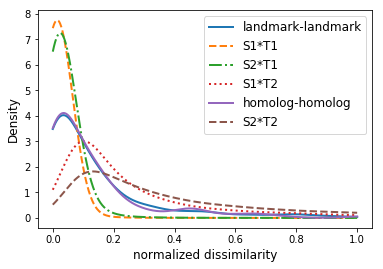

In [27]:
plot(dissim_scores_plots, 'normalized dissimilarity', xmax = 1)

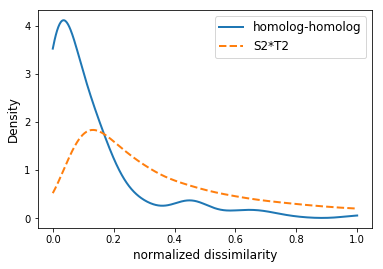

In [28]:
plot(dissim_scores_plots[-2:], 'normalized dissimilarity', xmax = 1)

In [29]:
T_CH_mags = np.linalg.norm(target_C_hat, axis=1)
T_CH_landmark_mags = np.take(T_CH_mags,target_landmark_idxs)
T_CH_non_landmark_mags = np.take(T_CH_mags,target_non_landmark_idxs)
print(T_CH_mags.shape)

(5609,)


In [30]:
print(mmm(T_CH_mags))
print(mmm(T_CH_landmark_mags))
print(mmm(T_CH_non_landmark_mags))

(0.00012454301079299526, 0.007850374308003968, 0.046514299765793646)
(0.0011044805287443113, 0.011866277279420445, 0.03346799131440868)
(0.00012454301079299526, 0.007541992432679225, 0.046514299765793646)


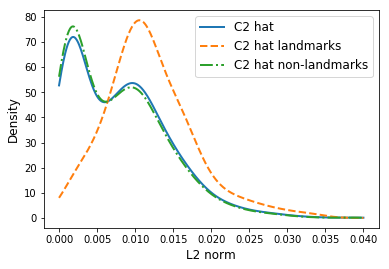

In [31]:
plot([(T_CH_mags, 'C2 hat'),
      (np.take(T_CH_mags,target_landmark_idxs), 'C2 hat landmarks'),
      (np.take(T_CH_mags,target_non_landmark_idxs), 'C2 hat non-landmarks')],'L2 norm', xmin=0, xmax=0.04)

In [32]:
T_CH_normalized = target_C_hat / np.mean(T_CH_mags) * np.mean(np.linalg.norm(source_C, axis=1))
D12_normalized = source_C @ T_CH_normalized.T

In [33]:
normalized_raw_scores = separate_scores(D12_normalized, landmark_idxs, homolog_idxs)
normalized_raw_plots = list(zip(normalized_raw_scores, ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))

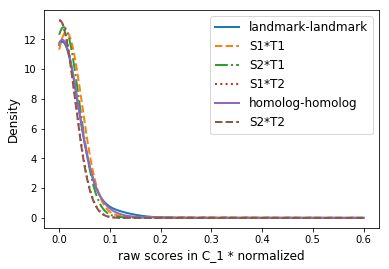

In [34]:
plot(normalized_raw_plots, 'raw scores in C_1 * normalized')

In [35]:
mmm(D12_normalized)

(8.902204404164293e-08, 0.003508005803350655, 3.480102591397258)

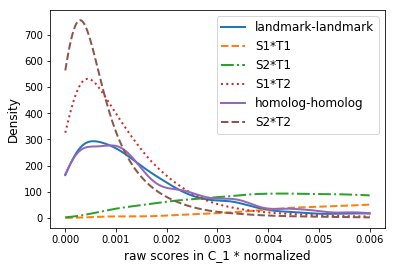

In [36]:
plot(normalized_raw_plots, 'raw scores in C_1 * normalized', xmax=0.006)

In [37]:
dissims_normalized = 1./ D12_normalized
dissims_normalized /= np.mean(dissims_normalized)
dissim_normalized_seps = separate_scores(dissims_normalized, landmark_idxs, homolog_idxs)
dissim_normalized_plots = list(zip(separate_scores(dissims_normalized, landmark_idxs, homolog_idxs),
                                   ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))



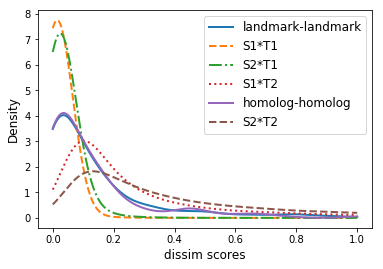

In [56]:
plot(dissim_normalized_plots, 'dissim scores', xmax=1)

In [39]:
source_C_normalized = source_C / np.linalg.norm(source_C, axis=0).reshape(-1,1)
D12_nn = source_C_normalized @ T_CH_normalized.T

In [40]:
dissims_nn = 1./ D12_nn

In [41]:
dissims_nn /= np.mean(dissims_nn)

In [42]:
dissim_nn_seps = separate_scores(dissims_nn, landmark_idxs, homolog_idxs)
dissim_nn_plots = list(zip(separate_scores(dissims_nn, landmark_idxs, homolog_idxs),
                                   ['landmark-landmark', 'S1*T1', 'S2*T1', 'S1*T2', 'homolog-homolog', 'S2*T2']))

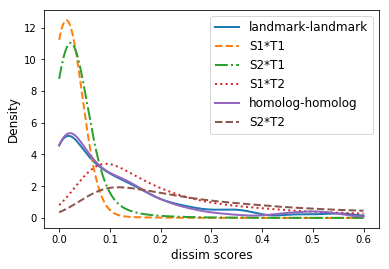

In [43]:
plot(dissim_nn_plots, 'dissim scores')

# Testing out function implemented in handl2.py

In [59]:
from handl2 import handl2_embed_matrices

In [60]:
source_C_handl2, target_C_handl2 = handl2_embed_matrices(source_C, target_D, landmark_idxs)

In [61]:
D12_handl2 = source_C_handl2 @ target_C_handl2.T
separated_handl2_raw_scores = separate_scores(D12_handl2, landmark_idxs, homolog_idxs)
handl2_raw_plots = list(zip(separated_handl2_raw_scores,
                         ['landmark-landmark', 'S1*T1', 'S1*T2', 'S2*T1', 'homolog-homolog', 'S2*T2']))

In [83]:
mmm(D12_handl2)

(8.902204404166326e-08, 0.003508005803350655, 3.480102591397257)

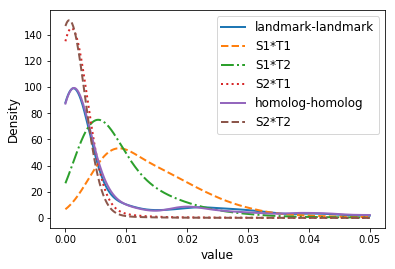

In [85]:
plot(handl2_raw_plots, 'value', xmin=0, xmax=0.05)

In [63]:
np.linalg.norm(D12_handl2 - D_12)

72.55956197946854

In [78]:
source_C_norms = np.linalg.norm(source_C, axis=1, ord=2)
target_C_norms = np.linalg.norm(target_C_handl2, axis=1, ord=2)
print(source_C_norms.shape, target_C_norms.shape)

(1865,) (5609,)


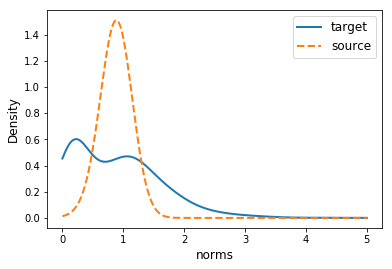

In [82]:
plot([(target_C_norms, 'target'),(source_C_norms,'source')],'norms', xmax=5, xmin=0)

In [80]:
mmm(target_C_norms)

(0.0138910725000734, 0.8756020749044715, 5.188035091031599)

In [81]:
mmm(source_C_norms)

(0.2704117547948808, 0.8756020749044716, 0.9554866119880617)

##### 